In [2]:
!pip install pykan

Usando dispositivo: cpu
Treino: torch.Size([6132, 14])
Validação: torch.Size([1314, 14])
Teste: torch.Size([1314, 14])
Epoch 0, Treino Loss: 1.4138, Val Loss: 1.1956
Epoch 1, Treino Loss: 1.3625, Val Loss: 1.1480
Epoch 2, Treino Loss: 1.3119, Val Loss: 1.0948
Epoch 3, Treino Loss: 1.2551, Val Loss: 1.0331
Epoch 4, Treino Loss: 1.1890, Val Loss: 0.9723
Epoch 5, Treino Loss: 1.1219, Val Loss: 0.9241
Epoch 6, Treino Loss: 1.0697, Val Loss: 0.8704
Epoch 7, Treino Loss: 1.0096, Val Loss: 0.8002
Epoch 8, Treino Loss: 0.9303, Val Loss: 0.7186
Epoch 9, Treino Loss: 0.8357, Val Loss: 0.6424
Epoch 10, Treino Loss: 0.7416, Val Loss: 0.6127
Epoch 14, Treino Loss: 0.6961, Val Loss: 0.5738
Epoch 15, Treino Loss: 0.6272, Val Loss: 0.5280
Epoch 16, Treino Loss: 0.5886, Val Loss: 0.5125
Epoch 17, Treino Loss: 0.5798, Val Loss: 0.5114
Epoch 18, Treino Loss: 0.5834, Val Loss: 0.5111
Epoch 19, Treino Loss: 0.5851, Val Loss: 0.5050
Epoch 20, Treino Loss: 0.5780, Val Loss: 0.4920
Epoch 21, Treino Loss: 0.56

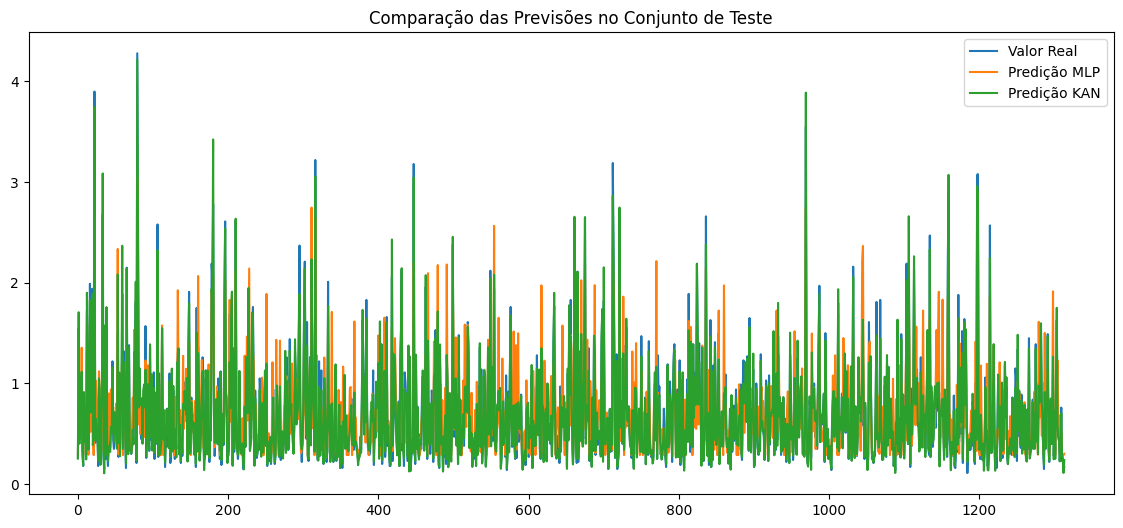

In [13]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from kan import KAN
from sympy import nsimplify
from kan.utils import ex_round
import random

# Configurar seed para reproducibilidade
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# Ler dataset
df = pd.read_csv("/content/ETSojaPerHour.csv")

# Converter timestamp para numérico
df["timestamp_local"] = pd.to_datetime(df["timestamp_local"])
df["timestamp_local"] = df["timestamp_local"].astype(int) / 10**9

feature_cols = ["lat","lon","ts","timestamp_local","slp","wind_spd","wind_dir",
                "temp","rh","dewpt","clouds","precip","solar_rad","uv"]
target_col = "ET0_KC"

X = df[feature_cols].astype(float).values
y = df[target_col].astype(float).values.reshape(-1,1)

# Normalização das features e target
scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)

X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

X_tensor = torch.tensor(X_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_norm, dtype=torch.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

print("Treino:", X_train.shape)
print("Validação:", X_val.shape)
print("Teste:", X_test.shape)

class MLP_ET(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLP_ET(input_dim=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# Treinamento com early stopping simples
n_epochs = 100
best_val_loss = float('inf')
patience = 30
counter = 0

for epoch in range(n_epochs):
    mlp_model.train()
    optimizer.zero_grad()
    output = mlp_model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    mlp_model.eval()
    val_output = mlp_model(X_val)
    val_loss = criterion(val_output, y_val)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        counter = 0
        best_model_wts = mlp_model.state_dict()
    else:
        counter += 1

    if epoch % 50 == 0 or counter == 0:
        print(f"Epoch {epoch}, Treino Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if counter >= patience:
        print("Early stopping MLP atingido.")
        break

mlp_model.load_state_dict(best_model_wts)

test_output = mlp_model(X_test)
test_loss = criterion(test_output, y_test)
print(f"MLP Test Loss (normalizado): {test_loss.item():.4f}")

# ------------------------------------------------------------------------------
# KAN
kan_model = KAN(
    width=[X_train.shape[1], 16, 8, 1],
    grid=10,
    k=3,
    seed=seed
).to(device)

optimizer_kan = torch.optim.Adam(kan_model.parameters(), lr=0.01)

best_val_loss_kan = float('inf')
counter_kan = 0

for epoch in range(n_epochs):
    kan_model.train()
    optimizer_kan.zero_grad()
    output_kan = kan_model(X_train)
    loss_kan = criterion(output_kan, y_train)
    loss_kan.backward()
    optimizer_kan.step()

    kan_model.eval()
    val_output_kan = kan_model(X_val)
    val_loss_kan = criterion(val_output_kan, y_val)

    if val_loss_kan.item() < best_val_loss_kan:
        best_val_loss_kan = val_loss_kan.item()
        counter_kan = 0
        best_model_kan_wts = kan_model.state_dict()
    else:
        counter_kan += 1

    if epoch % 50 == 0 or counter_kan == 0:
        print(f"[KAN] Epoch {epoch}, Treino Loss: {loss_kan.item():.4f}, Val Loss: {val_loss_kan.item():.4f}")

    if counter_kan >= patience:
        print("Early stopping KAN atingido.")
        break

kan_model.load_state_dict(best_model_kan_wts)

test_output_kan = kan_model(X_test)
test_loss_kan = criterion(test_output_kan, y_test)
print(f"[KAN] Test Loss (normalizado): {test_loss_kan.item():.4f}")

# Visualização gráfica comparativa
def plot_predictions(true, pred_mlp, pred_kan, scaler_y):
    true = scaler_y.inverse_transform(true.cpu().detach().numpy())
    pred_mlp = scaler_y.inverse_transform(pred_mlp.cpu().detach().numpy())
    pred_kan = scaler_y.inverse_transform(pred_kan.cpu().detach().numpy())

    plt.figure(figsize=(14, 6))
    plt.plot(true, label="Valor Real")
    plt.plot(pred_mlp, label="Predição MLP")
    plt.plot(pred_kan, label="Predição KAN")
    plt.legend()
    plt.title("Comparação das Previsões no Conjunto de Teste")
    plt.show()

plot_predictions(y_test, test_output, test_output_kan, scaler_y)

# Visualizar funções phi da KAN
#kan_model.plot()

# Fórmula simbólica
#kan_model.auto_symbolic(verbose=2)
#formula = kan_model.symbolic_formula()[0][0]
#print("Fórmula simbólica simplificada:")
#print(nsimplify(ex_round(formula, 1)))


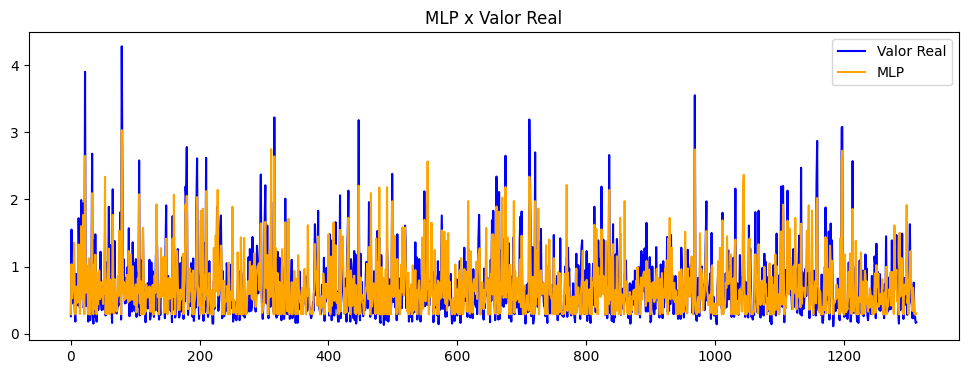

In [20]:
def plot_separado(true, pred_mlp, pred_kan, scaler_y):
    # Inverter a normalização
    true = scaler_y.inverse_transform(true.cpu().detach().numpy())
    pred_mlp = scaler_y.inverse_transform(pred_mlp.cpu().detach().numpy())
    pred_kan = scaler_y.inverse_transform(pred_kan.cpu().detach().numpy())

    # MLP x Real
    plt.figure(figsize=(12,4))
    plt.plot(true, label="Valor Real", color='blue')
    plt.plot(pred_mlp, label="MLP", color='orange')
    plt.title("MLP x Valor Real")
    plt.legend()
    plt.show()

plot_separado(y_test, test_output, test_output_kan, scaler_y)

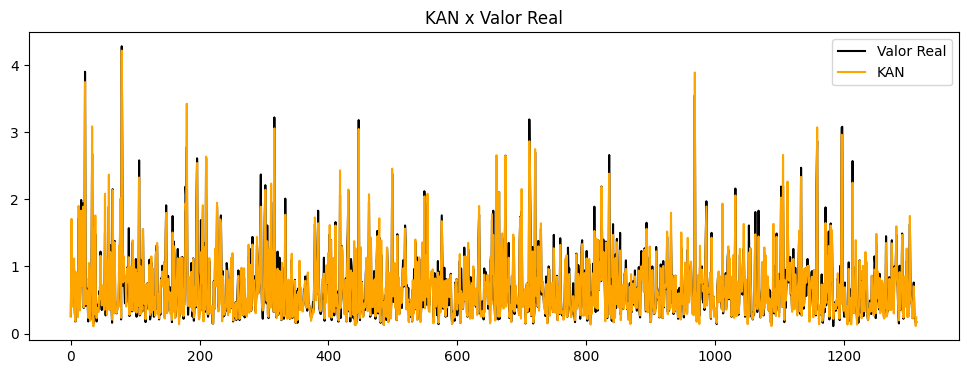

In [19]:
def plot_separado(true, pred_mlp, pred_kan, scaler_y):
    # Inverter a normalização
    true = scaler_y.inverse_transform(true.cpu().detach().numpy())
    pred_mlp = scaler_y.inverse_transform(pred_mlp.cpu().detach().numpy())
    pred_kan = scaler_y.inverse_transform(pred_kan.cpu().detach().numpy())

    # KAN x Real
    plt.figure(figsize=(12,4))
    plt.plot(true, label="Valor Real", color='black')
    plt.plot(pred_kan, label="KAN", color='orange')
    plt.title("KAN x Valor Real")
    plt.legend()
    plt.show()

# Chamar a função
plot_separado(y_test, test_output, test_output_kan, scaler_y)
